In [1]:
import sys
sys.path.append("../../")
from simulation_classes.drones import Drones
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

続いてドローンの初期化を行う。
複数台の巡行をシミュレートする。

N: ドローン台数

In [16]:
N = 40
T = 1000
delta_t = 0.1
initial_delta_x = 0.1
drone_list = []

# ここで一気に初期化
for i in range(N):
  xcor = initial_delta_x * (N -i)
  v = 1 if i==0 else 0
  drone = Drones(xcor, 0, v, 1,1)
  drone_list.append(drone)


In [17]:
# ここからシミュレーション開始
for i in range(T):
  if i == 400:
    wind_speed = 0.4
    for drone_i in drone_list:
      next_speed = max(drone_i.v_x - wind_speed, 0)
      drone_i.force_velocity_change(next_speed)
    
  for idx,drone_i in enumerate(drone_list):
    if idx == 0:
      leader = drone_list[idx]
      leader.leader_update(delta_t)
      leader.record()
    else:
      follower = drone_list[idx]
      delta_x = drone_list[idx-1].xcor - follower.xcor
      follower.update(delta_t,delta_x )
      follower.record()


Text(0, 0.5, 'time')

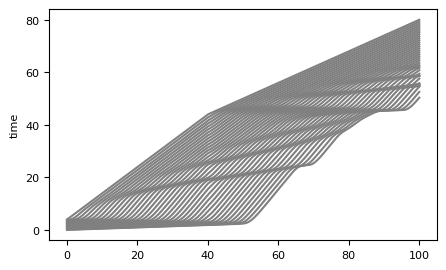

In [21]:
t = np.linspace(0,delta_t*(T+1), T+1)

plt.figure(figsize=(5,3))
for drone in drone_list:
    plt.plot(t,np.array(drone.xcorList), color="gray")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.ylabel("time", fontsize=8)

In [22]:
dir(d_0)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'a',
 'bark',
 'c',
 'leader_update',
 'record',
 'update',
 'v_x',
 'v_xList',
 'xcor',
 'xcorList',
 'ycor']